# Установка Библиотек

In [2]:
import pandas as pd
import numpy as np
from collections import Counter
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import re
from IPython.display import display
from sklearn import preprocessing, svm
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression

# Подгрузка данных

In [3]:
hotels = pd.read_csv('hotels.csv')
hotels.head(1)

,hotel_address,additional_number_of_scoring,review_date,average_score,hotel_name,reviewer_nationality,negative_review,review_total_negative_word_counts,total_number_of_reviews,positive_review,review_total_positive_word_counts,total_number_of_reviews_reviewer_has_given,reviewer_score,tags,days_since_review,lat,lng
0,Stratton Street Mayfair Westminster Borough Lo...,581,2/19/2016,8.4,The May Fair Hotel,United Kingdom,Leaving,3,1994,Staff were amazing,4,7,10.0,"[' Leisure trip ', ' Couple ', ' Studio Suite ...",531 day,51.507894,-0.143671


In [ ]:
# Подгрузим наши данные из соревнования
DATA_DIR = '/kaggle/input/sf-booking/'
df_train = pd.read_csv(DATA_DIR+'/hotels_train.csv') # датасет для обучения
df_test = pd.read_csv(DATA_DIR+'hotels_test.csv') # датасет для предсказания
sample_submission = pd.read_csv(DATA_DIR+'/submission.csv') # самбмишн

# Сбор данных

In [3]:
hotels.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 386803 entries, 0 to 386802
Data columns (total 17 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   hotel_address                               386803 non-null  object 
 1   additional_number_of_scoring                386803 non-null  int64  
 2   review_date                                 386803 non-null  object 
 3   average_score                               386803 non-null  float64
 4   hotel_name                                  386803 non-null  object 
 5   reviewer_nationality                        386803 non-null  object 
 6   negative_review                             386803 non-null  object 
 7   review_total_negative_word_counts           386803 non-null  int64  
 8   total_number_of_reviews                     386803 non-null  int64  
 9   positive_review                             386803 non-null  object 
 

In [ ]:
# df_train.shape[0], df_test.shape[0], sample_submission.shape[0] 

Получение данных

In [4]:
# import sweetviz as sv

In [ ]:
# report = sv.analyze(hotels)
 #report.show_html()

# Очистка данных

### Удаление дубликатов

In [5]:
duplicates = hotels[hotels.duplicated(subset=hotels.columns)]

hotels = hotels.drop_duplicates()
print(duplicates.shape[0])

307


In [ ]:
mask = df_train.duplicated(subset = df_train.columns)
data_duplicates = df_train[mask]
print(f'Число найденных и удаленных дубликатов: {data_duplicates.shape[0]}')

df_train = df_train.drop_duplicates(subset = df_train.columns) # удаление найденных дубликатов

### Поиск нулевых значений

In [6]:
null_data = hotels.isnull().sum()
print(null_data[null_data > 0])

lat    2448
lng    2448
dtype: int64


### Тепловая карта пропусков

In [4]:
cols_null_percent = hotels.isnull().mean() * 100
cols_with_null = cols_null_percent[cols_null_percent>0].sort_values(ascending=False)
display(cols_with_null)

lat    0.63288
lng    0.63288
dtype: float64

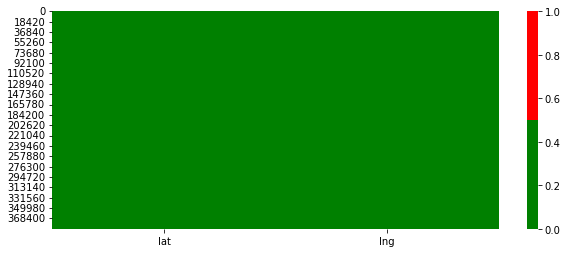

In [5]:
colors = ['green', 'red'] 
fig = plt.figure(figsize=(10, 4))
cols = cols_with_null.index
ax = sns.heatmap(
    hotels[cols].isnull(),
    cmap=sns.color_palette(colors),
)

# EDA

## Feature selection (отбор признаков) (статистические тесты значимости)

кодирование численного признака .за счет интервала

Создание признака. отбор значимых признаков. проверка и постановка гипотез. кодирование признаков

Создание призака страна и город

In [15]:
def split_func(row):
    res = row.split(sep=None)[-2:]
    return res
hotels['address']=hotels['hotel_address'].apply(split_func)

In [24]:
def split_func(row):
    res = (' '.join(row.split(' ')[-3:]))
    return res
hotels['address']=hotels['hotel_address'].apply(split_func)

In [25]:
hotels['address'].nunique()

566

In [26]:
print(hotels['address'].nunique)

<bound method IndexOpsMixin.nunique of 0               8LT United Kingdom
1               5AF United Kingdom
2               75006 Paris France
3               75019 Paris France
4         AG Amsterdam Netherlands
                    ...           
386798          0TP United Kingdom
386799         1030 Vienna Austria
386800          6HG United Kingdom
386801          7TA United Kingdom
386802          0PG United Kingdom
Name: address, Length: 386803, dtype: object>


In [60]:
hotels.iloc[386764]['hotel_address']

'W hringer Stra e 33 35 09 Alsergrund 1090 Vienna Austria'

In [71]:
hotels.loc[hotels['hotel_address']== 'W hringer Stra e 33 35 09 Alsergrund 1090 Vienna Austria'].describe()

,additional_number_of_scoring,average_score,review_total_negative_word_counts,total_number_of_reviews,review_total_positive_word_counts,total_number_of_reviews_reviewer_has_given,reviewer_score,lat,lng,lat1
count,285.0,2.850000e+02,285.000000,285.0,285.000000,285.000000,285.000000,0.0,0.0,144.000000
mean,214.0,7.800000e+00,18.614035,2724.0,17.596491,6.550877,7.691579,NaN,NaN,48.220172
std,0.0,1.423585e-14,29.416122,0.0,22.795215,8.365024,1.798669,NaN,NaN,0.003356
min,214.0,7.800000e+00,0.000000,2724.0,0.000000,1.000000,2.500000,NaN,NaN,48.216334
25%,214.0,7.800000e+00,0.000000,2724.0,5.000000,1.000000,7.100000,NaN,NaN,48.216334
50%,214.0,7.800000e+00,10.000000,2724.0,12.000000,4.000000,7.900000,NaN,NaN,48.219943
75%,214.0,7.800000e+00,22.000000,2724.0,22.000000,9.000000,8.800000,NaN,NaN,48.221770
max,214.0,7.800000e+00,238.000000,2724.0,255.000000,58.000000,10.000000,NaN,NaN,48.230701


In [69]:
hotels['lat1'] = hotels.sort_values(by=['address'], ascending=True).groupby(['address'])['lat'].shift(1)

Применяем тип дата к колонке дата рецензии

In [8]:
hotels['review_date'] = pd.to_datetime(hotels['review_date'])

Оставляем только числовой признак у колонки

In [9]:
regex = '\d{3}' # регулярное выражение для нахождения чисел
hotels['days_since_review'] = hotels['days_since_review'].str.findall(regex).str.get(0)


## Тепловая карта пропусков

In [10]:
cols_null_percent = hotels.isnull().mean() * 100
cols_with_null = cols_null_percent[cols_null_percent>0].sort_values(ascending=False)
display(cols_with_null)

days_since_review    14.697694
lat                   0.633383
lng                   0.633383
dtype: float64

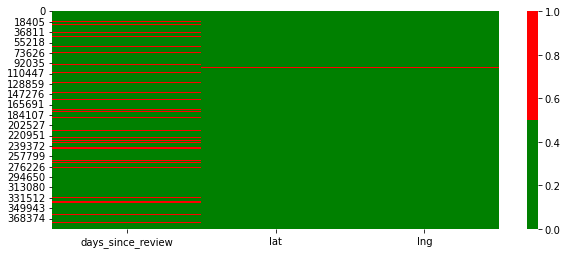

In [11]:
colors = ['green', 'red'] 
fig = plt.figure(figsize=(10, 4))
cols = cols_with_null.index
ax = sns.heatmap(
    hotels[cols].isnull(),
    cmap=sns.color_palette(colors),
)

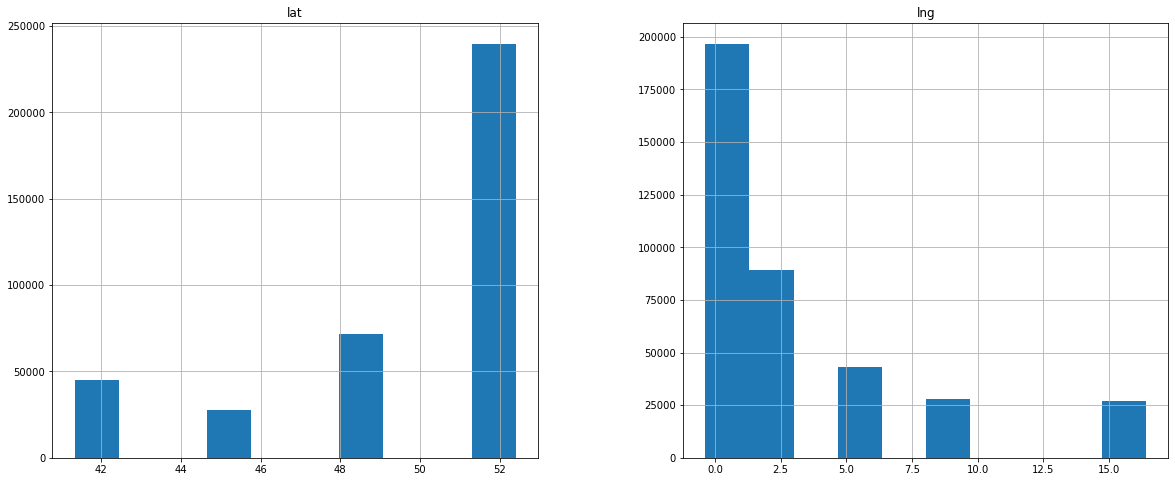

In [11]:
cols = cols_with_null.index
hotels[cols].hist(figsize=(20, 8));

Вариант с заполнением пустых значений медианной. (Для распределений, похожих на логнормальное, где пик близ нуля, а далее наблюдается постепенный спад частоты, высока вероятность наличия выбросов (о них мы поговорим чуть позже). Математически доказывается, что среднее очень чувствительно к выбросам, а вот медиана — нет. Поэтому предпочтительнее использовать медианное значение для таких признаков.)

In [12]:
#создаем копию исходной таблицы
fill_data = hotels.copy()
#создаем словарь имя столбца: число(признак) на который надо заменить пропуски
values = {
    'days_since_review': fill_data['days_since_review'].median(),
    'lat': fill_data['lat'].median(),
    'lng': fill_data['lng'].median()
}
#заполняем пропуски в соответствии с заявленным словарем
fill_data = fill_data.fillna(values)
#выводим результирующую долю пропусков
fill_data.isnull().mean()

hotel_address                                 0.0
additional_number_of_scoring                  0.0
review_date                                   0.0
average_score                                 0.0
hotel_name                                    0.0
reviewer_nationality                          0.0
negative_review                               0.0
review_total_negative_word_counts             0.0
total_number_of_reviews                       0.0
positive_review                               0.0
review_total_positive_word_counts             0.0
total_number_of_reviews_reviewer_has_given    0.0
reviewer_score                                0.0
tags                                          0.0
days_since_review                             0.0
lat                                           0.0
lng                                           0.0
address                                       0.0
dtype: float64

Посмотрим как изменились рапределения признаков


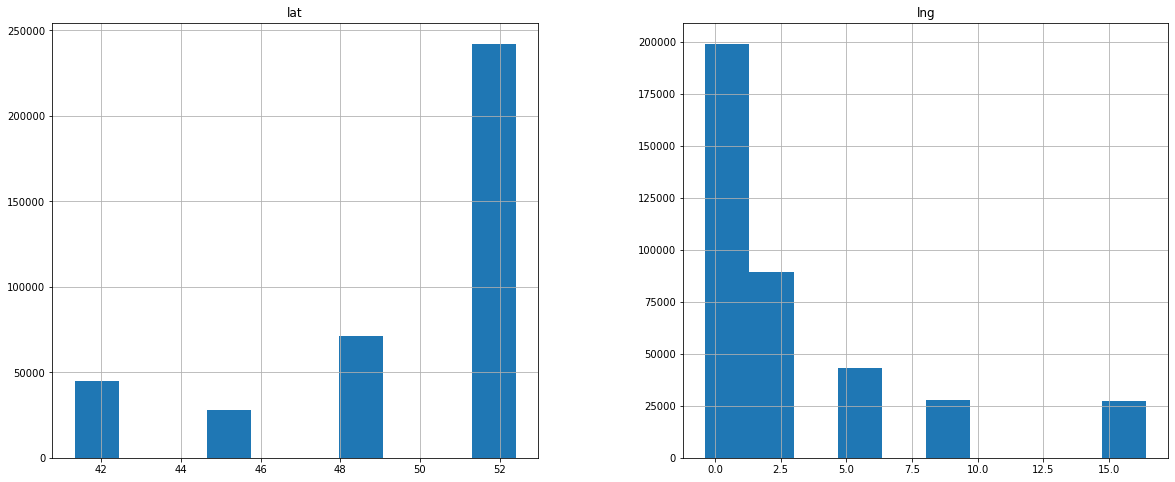

In [13]:
cols = cols_with_null.index
fill_data[cols].hist(figsize=(20, 8));

## Комбинирование методов

In [14]:
#создаём копию исходной таблицы
combine_data = hotels.copy()

#отбрасываем столбцы с числом пропусков более 30% (100-70)
n = combine_data.shape[0] #число строк в таблице
thresh = n*0.7
combine_data = combine_data.dropna(how='any', thresh=thresh, axis=1)

#отбрасываем строки с числом пропусков более 2 в строке
m = combine_data.shape[1] #число признаков после удаления столбцов
combine_data = combine_data.dropna(how='any', thresh=m-2, axis=0)

#создаём словарь 'имя_столбца': число (признак), на который надо заменить пропуски 
values = {
    'days_since_review': fill_data['days_since_review'].median(),
    'lat': fill_data['lat'].median(),
    'lng': fill_data['lng'].median()
}
#заполняем оставшиеся записи константами в соответствии со словарем values
combine_data = combine_data.fillna(values)
#выводим результирующую долю пропусков
display(combine_data.isnull().mean())

hotel_address                                 0.0
additional_number_of_scoring                  0.0
review_date                                   0.0
average_score                                 0.0
hotel_name                                    0.0
reviewer_nationality                          0.0
negative_review                               0.0
review_total_negative_word_counts             0.0
total_number_of_reviews                       0.0
positive_review                               0.0
review_total_positive_word_counts             0.0
total_number_of_reviews_reviewer_has_given    0.0
reviewer_score                                0.0
tags                                          0.0
days_since_review                             0.0
lat                                           0.0
lng                                           0.0
address                                       0.0
dtype: float64

Вариант с удалением пустых значений

In [ ]:

""""""""""
#создаем копию исходной таблицы
drop_data = hotels.copy()
#задаем минимальный порог: вычисляем 70% от числа строк
thresh = drop_data.shape[0]*0.7
#удаляем столбцы, в которых более 30% (100-70) пропусков
drop_data = drop_data.dropna(how='any', thresh=thresh, axis=1)
#удаляем записи, в которых есть хотя бы 1 пропуск
drop_data = drop_data.dropna(how='any', axis=0)
#отображаем результирующую долю пропусков
drop_data.isnull().mean()
"""""""

# Поиск выбрасов

## Метод межкваритльного размаха (метод Тьюки)

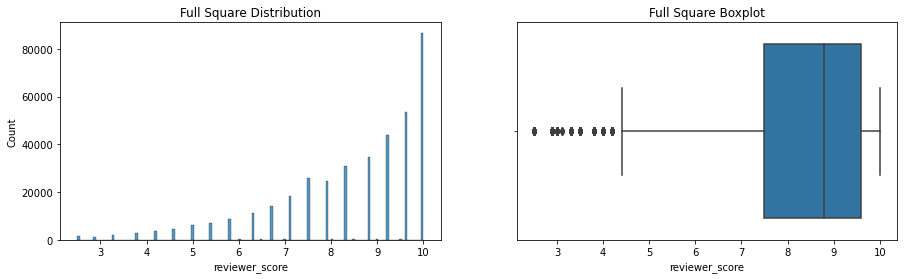

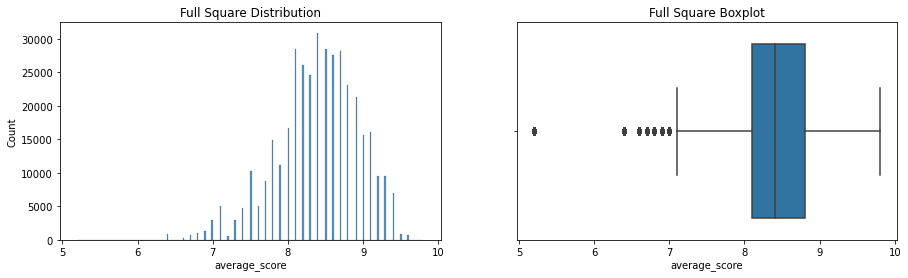

In [15]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 4))
histplot = sns.histplot(data=combine_data, x='reviewer_score', ax=axes[0]);
histplot.set_title('Full Square Distribution');
boxplot = sns.boxplot(data=combine_data, x='reviewer_score', ax=axes[1]);
boxplot.set_title('Full Square Boxplot');
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 4))
histplot = sns.histplot(data=combine_data, x='average_score', ax=axes[0]);
histplot.set_title('Full Square Distribution');
boxplot = sns.boxplot(data=combine_data, x='average_score', ax=axes[1]);
boxplot.set_title('Full Square Boxplot');

Приведение к логарифмическому виду

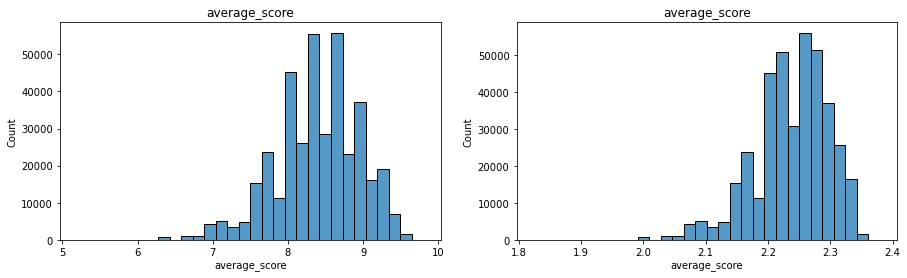

In [16]:
fig, axes = plt.subplots(1, 2, figsize=(15, 4))

#гистограмма исходного признака
histplot = sns.histplot(combine_data['average_score'], bins=30, ax=axes[0])
histplot.set_title('average_score');

#гистограмма в логарифмическом масштабе
log_reviewer_score= np.log(combine_data['average_score'] + 1)
histplot = sns.histplot(log_reviewer_score , bins=30, ax=axes[1])
histplot.set_title('average_score');

In [17]:
combine_data['average_score'].describe()

count    386138.000000
mean          8.397446
std           0.548005
min           5.200000
25%           8.100000
50%           8.400000
75%           8.800000
max           9.800000
Name: average_score, dtype: float64

In [18]:
print(combine_data[combine_data['average_score'] == 5.2].shape[0])

44


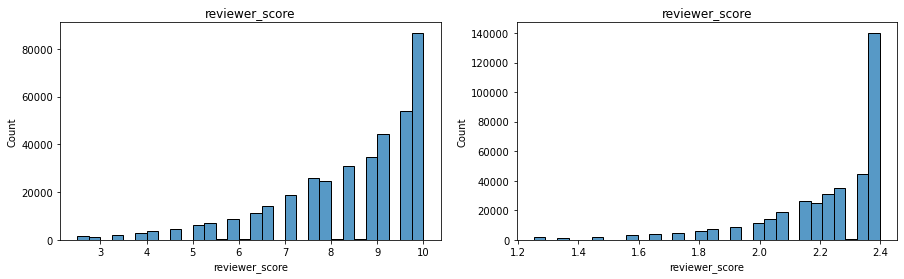

In [19]:
fig, axes = plt.subplots(1, 2, figsize=(15, 4))

#гистограмма исходного признака
histplot = sns.histplot(combine_data['reviewer_score'], bins=30, ax=axes[0])
histplot.set_title('reviewer_score');

#гистограмма в логарифмическом масштабе
log_reviewer_score= np.log(combine_data['reviewer_score'] + 1)
histplot = sns.histplot(log_reviewer_score , bins=30, ax=axes[1])
histplot.set_title('reviewer_score');

In [20]:
def outliers_iqr(data, feature):
    x = data[feature]
    quartile_1, quartile_3 = x.quantile(0.25), x.quantile(0.75),
    iqr = quartile_3 - quartile_1
    lower_bound = quartile_1 - (iqr * 1.5)
    upper_bound = quartile_3 + (iqr * 1.5)
    outliers = data[(x<lower_bound) | (x > upper_bound)]
    cleaned = data[(x>lower_bound) & (x < upper_bound)]
    return outliers, cleaned

In [21]:
outliers, cleaned = outliers_iqr(combine_data, 'average_score')
print(f'Число выбросов по методу Тьюки: {outliers.shape[0]}')
print(f'Результирующее число записей: {cleaned.shape[0]}')

Число выбросов по методу Тьюки: 7137
Результирующее число записей: 379001


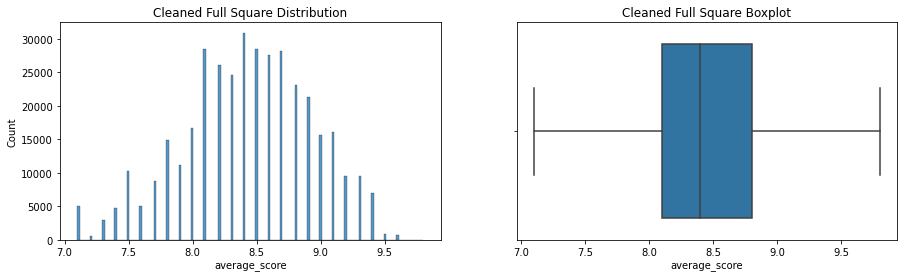

In [22]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 4))
histplot = sns.histplot(data=cleaned, x='average_score', ax=axes[0]);
histplot.set_title('Cleaned Full Square Distribution');
boxplot = sns.boxplot(data=cleaned, x='average_score', ax=axes[1]);
boxplot.set_title('Cleaned Full Square Boxplot');

In [69]:
алтернатинвый fill_data 
'''''
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 4))
histplot = sns.histplot(data=fill_data, x='reviewer_score', ax=axes[0]);
histplot.set_title('Full Square Distribution');
boxplot = sns.boxplot(data=fill_data, x='reviewer_score', ax=axes[1]);
boxplot.set_title('Full Square Boxplot');
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 4))
histplot = sns.histplot(data=fill_data, x='average_score', ax=axes[0]);
histplot.set_title('Full Square Distribution');
boxplot = sns.boxplot(data=fill_data, x='average_score', ax=axes[1]);
boxplot.set_title('Full Square Boxplot'); 


SyntaxError: EOF while scanning triple-quoted string literal (Temp/ipykernel_5960/1554698482.py, line 11)

Создание нового признака

In [203]:
regex = '\d{3}' # регулярное выражение для нахождения чисел
cleaned['days_since_review'] = cleaned['days_since_review'].str.findall(regex).str.get(0)

C:\Users\123\AppData\Local\Temp/ipykernel_2464/1238211686.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cleaned['days_since_review'] = cleaned['days_since_review'].str.findall(regex).str.get(0)


Создать словарь с подсчетом слов столбце 

In [27]:
cleaned.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 379001 entries, 0 to 386802
Data columns (total 8 columns):
 #   Column                             Non-Null Count   Dtype  
---  ------                             --------------   -----  
 0   additional_number_of_scoring       379001 non-null  int64  
 1   average_score                      379001 non-null  float64
 2   review_total_negative_word_counts  379001 non-null  int64  
 3   total_number_of_reviews            379001 non-null  int64  
 4   review_total_positive_word_counts  379001 non-null  int64  
 5   reviewer_score                     379001 non-null  float64
 6   lat                                379001 non-null  float64
 7   lng                                379001 non-null  float64
dtypes: float64(4), int64(4)
memory usage: 26.0 MB


# Отбор признаков


Удаляем столбцы с типом object

In [24]:
cleaned = cleaned.drop(columns=['review_date','address', 'hotel_address', 'hotel_name', 'reviewer_nationality', 'negative_review', 'positive_review', 'tags', 'days_since_review'], axis = 1)  

Анализ мультиколлинеарности

<AxesSubplot:>

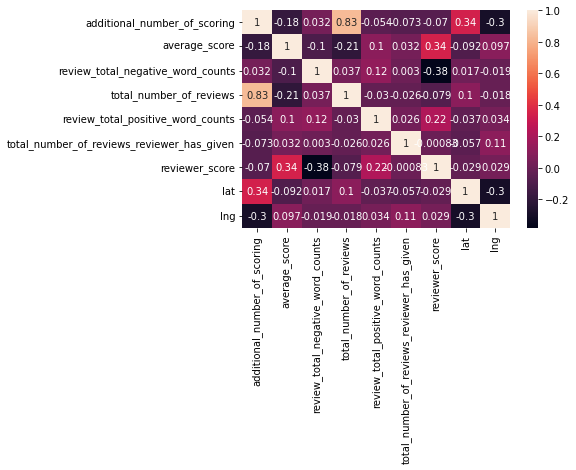

In [25]:
sns.heatmap(cleaned.corr(), annot=True)

In [26]:
# столбцы total_number_or_reviews и total_number_of_reviews_reviewer_has_given сила связи между переменными "высокая". Удалим столбец total_number_of_reviews_reviewer_has_given
cleaned = cleaned.drop(columns=['total_number_of_reviews_reviewer_has_given'], axis=1)

экспорт очищенных данных

In [35]:
cleaned.to_csv('data_sep', index=False)

In [36]:
data_sep=pd.read_csv('data_sep')


In [37]:
data_sep.head()

,additional_number_of_scoring,average_score,review_total_negative_word_counts,total_number_of_reviews,review_total_positive_word_counts,reviewer_score,lat,lng
0,581,8.4,3,1994,4,10.0,51.507894,-0.143671
1,299,8.3,3,1361,2,6.3,51.521009,-0.123097
2,32,8.9,6,406,0,7.5,48.845377,2.325643
3,34,7.5,0,607,11,10.0,48.888697,2.394540
4,914,8.5,4,7586,20,9.6,52.385601,4.847060


## Кодирование признаков (нормализация и стандартизация)

In [39]:
col_names = list(cleaned.columns)

# MimMaxScaler

In [38]:
# инициализируем нормализатор MinMaxScaler
mm_scaler = preprocessing.MinMaxScaler()

# копируем исходный датасет
df_mm = mm_scaler.fit_transform(cleaned)

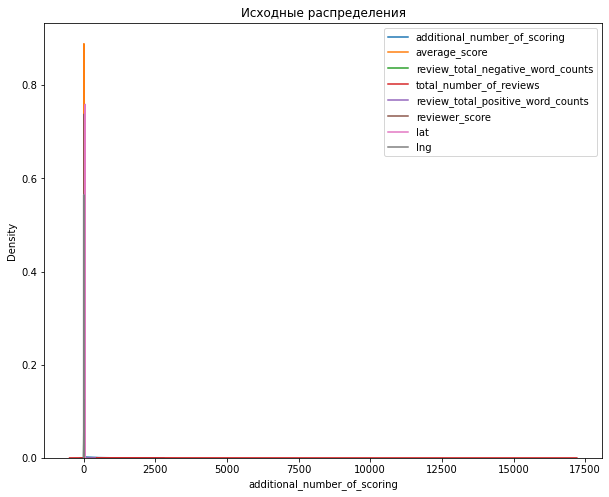

In [40]:
# Преобразуем промежуточный датасет в полноценный датафрейм для визуализации
df_mm = pd.DataFrame(df_mm, columns=col_names)

# зададим параметры холста, название и визуализируем кривые распределения:
fig, (ax1) = plt.subplots(ncols=1, figsize=(10, 8))
ax1.set_title('Исходные распределения')

# kdeplot() (KDE – оценка плотности ядра) – специальный метод для графиков распределений
sns.kdeplot(cleaned['additional_number_of_scoring'], ax=ax1, label ='additional_number_of_scoring')
sns.kdeplot(cleaned['average_score'], ax=ax1, label ='average_score')
sns.kdeplot(cleaned['review_total_negative_word_counts'], ax=ax1, label ='review_total_negative_word_counts')
sns.kdeplot(cleaned['total_number_of_reviews'], ax=ax1, label ='total_number_of_reviews')
sns.kdeplot(cleaned['review_total_positive_word_counts'], ax=ax1, label ='review_total_positive_word_counts')
sns.kdeplot(cleaned['reviewer_score'], ax=ax1, label ='reviewer_score')
sns.kdeplot(cleaned['lat'], ax=ax1, label ='lat')
sns.kdeplot(cleaned['lng'], ax=ax1, label ='lng')
plt.legend()

# ROBUSTSCALER

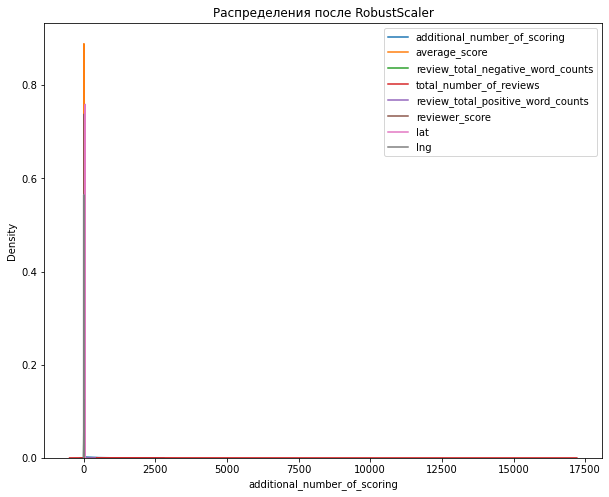

In [41]:
# инициализируем нормализатор RobustScaler
r_scaler = preprocessing.RobustScaler()

# копируем исходный датасет
df_r = r_scaler.fit_transform(cleaned)

# Преобразуем промежуточный датасет в полноценный датафрейм для визуализации
df_r = pd.DataFrame(df_r, columns=col_names)

fig, (ax1) = plt.subplots(ncols=1, figsize=(10, 8))
ax1.set_title('Распределения после RobustScaler')

# kdeplot() (KDE – оценка плотности ядра) – специальный метод для графиков распределений
sns.kdeplot(cleaned['additional_number_of_scoring'], ax=ax1, label ='additional_number_of_scoring')
sns.kdeplot(cleaned['average_score'], ax=ax1, label ='average_score')
sns.kdeplot(cleaned['review_total_negative_word_counts'], ax=ax1, label ='review_total_negative_word_counts')
sns.kdeplot(cleaned['total_number_of_reviews'], ax=ax1, label ='total_number_of_reviews')
sns.kdeplot(cleaned['review_total_positive_word_counts'], ax=ax1, label ='review_total_positive_word_counts')
sns.kdeplot(cleaned['reviewer_score'], ax=ax1, label ='reviewer_score')
sns.kdeplot(cleaned['lat'], ax=ax1, label ='lat')
sns.kdeplot(cleaned['lng'], ax=ax1, label ='lng')
plt.legend()

# СТАНДАРТИЗАЦИЯ 

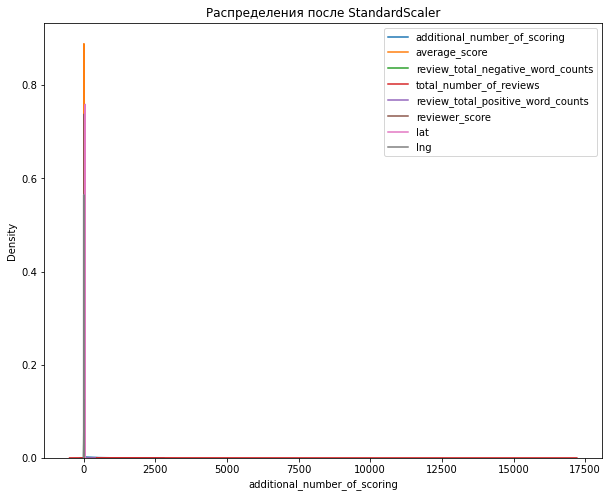

In [42]:
# инициализируем стандартизатор StandardScaler
s_scaler = preprocessing.StandardScaler()

# копируем исходный датасет
df_s = s_scaler.fit_transform(cleaned)

# Преобразуем промежуточный датасет в полноценный датафрейм для визуализации
df_s = pd.DataFrame(df_s, columns=col_names)

fig, (ax1) = plt.subplots(ncols=1, figsize=(10, 8))
ax1.set_title('Распределения после StandardScaler')

sns.kdeplot(cleaned['additional_number_of_scoring'], ax=ax1, label ='additional_number_of_scoring')
sns.kdeplot(cleaned['average_score'], ax=ax1, label ='average_score')
sns.kdeplot(cleaned['review_total_negative_word_counts'], ax=ax1, label ='review_total_negative_word_counts')
sns.kdeplot(cleaned['total_number_of_reviews'], ax=ax1, label ='total_number_of_reviews')
sns.kdeplot(cleaned['review_total_positive_word_counts'], ax=ax1, label ='review_total_positive_word_counts')
sns.kdeplot(cleaned['reviewer_score'], ax=ax1, label ='reviewer_score')
sns.kdeplot(cleaned['lat'], ax=ax1, label ='lat')
sns.kdeplot(cleaned['lng'], ax=ax1, label ='lng')
plt.legend()

# Задание 4.2

In [131]:
len(hotels['hotel_name'].unique())

1492

In [198]:
a_df = len(hotels.groupby(['hotel_name']))
a_df
#либо
print(len(hotels.groupby(['hotel_name'])))

1492


In [137]:
hotels['hotel_name'].value_counts()

Britannia International Hotel Canary Wharf           3587
Strand Palace Hotel                                  3206
Park Plaza Westminster Bridge London                 3095
Copthorne Tara Hotel London Kensington               2688
DoubleTree by Hilton Hotel London Tower of London    2379
                                                     ... 
Ibis Styles Milano Palmanova                            7
Renaissance Paris Republique Hotel Spa                  7
Hotel Wagner                                            6
Hotel Gallitzinberg                                     6
Mercure Paris Porte d Orleans                           5
Name: hotel_name, Length: 1492, dtype: int64

In [139]:
hotels['hotel_name'].nunique()

1492

In [141]:
hotels['hotel_name'].describe()

count                                         386803
unique                                          1492
top       Britannia International Hotel Canary Wharf
freq                                            3587
Name: hotel_name, dtype: object

In [142]:
len(set(hotels['hotel_name']))

1492

# Задание 4.3

In [143]:
hotels['review_date'] = pd.to_datetime(hotels['review_date'])

In [144]:
hotels['review_date'].describe()

C:\Users\123\AppData\Local\Temp/ipykernel_11936/3709708957.py:1: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  hotels['review_date'].describe()


count                  386803
unique                    731
top       2017-08-02 00:00:00
freq                     1911
first     2015-08-04 00:00:00
last      2017-08-03 00:00:00
Name: review_date, dtype: object

# Задание 4.4

In [113]:
tags = list() # множество тегов
for i, row in hotels['tags'].items():
    tmp = row.replace("[' ", "")
    tmp = tmp.replace(" ']", '')
    tmp = tmp.split(" ', ' ")
    for el in tmp:
        if el not in tags:
            tags.append(el)
print(f'Уникальных тегов = {len(tags)}')


Уникальных тегов = 2368


# Задание 4.5

In [146]:
cnt = Counter() 
for i, row in hotels['tags'].items():
    tmp = row.replace("[' ", "")
    tmp = tmp.replace(" ']", '')
    tmp = tmp.split(" ', ' ")
    cnt.update(tmp)
print(cnt.most_common(1))
#или так
for key, values in cnt.most_common(1): 
    print(key)
    




[('Leisure trip', 313353)]
Leisure trip


# Задание 4.6

In [197]:
cnt_data = pd.Series(cnt)
((cnt_data.sort_values(ascending=False)).head())




Leisure trip                      313353
Submitted from a mobile device    230608
Couple                            189046
Stayed 1 night                    145296
Stayed 2 nights                   100176
dtype: int64

# Преобразование признаков

In [38]:
cleaned.head()

,additional_number_of_scoring,average_score,review_total_negative_word_counts,total_number_of_reviews,review_total_positive_word_counts,reviewer_score,lat,lng
0,581,8.4,3,1994,4,10.0,51.507894,-0.143671
1,299,8.3,3,1361,2,6.3,51.521009,-0.123097
2,32,8.9,6,406,0,7.5,48.845377,2.325643
3,34,7.5,0,607,11,10.0,48.888697,2.394540
4,914,8.5,4,7586,20,9.6,52.385601,4.847060


In [50]:
df_s.head()

,additional_number_of_scoring,average_score,review_total_negative_word_counts,total_number_of_reviews,review_total_positive_word_counts,reviewer_score,lat,lng
0,0.157899,-0.053391,-0.520604,-0.324352,-0.636445,0.974670,0.598905,-0.648561
1,-0.401232,-0.250502,-0.520604,-0.595717,-0.728224,-1.321736,0.602677,-0.644084
2,-0.930622,0.932164,-0.418781,-1.005122,-0.820004,-0.576955,-0.166873,-0.111198
3,-0.926656,-1.827390,-0.622428,-0.918954,-0.315217,0.974670,-0.154414,-0.096205
4,0.818149,0.143720,-0.486663,2.072916,0.097790,0.726410,0.851346,0.437503


# Отбор признаков

In [43]:
# Разбиваем датафрейм на части, необходимые для обучения и тестирования модели  
# Х - данные с информацией об отелях, у - целевая переменная (рейтинги отелей)  
X = df_mm.drop(['reviewer_score'], axis = 1)  
y = df_mm['reviewer_score'] 

In [44]:
# Загружаем специальный инструмент для разбивки:  
from sklearn.model_selection import train_test_split  

In [45]:
# Наборы данных с меткой "train" будут использоваться для обучения модели, "test" - для тестирования.  
# Для тестирования мы будем использовать 25% от исходного датасета.  
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

In [46]:
# Импортируем необходимые библиотеки:  
from sklearn.ensemble import RandomForestRegressor # инструмент для создания и обучения модели  
from sklearn import metrics # инструменты для оценки точности модели  
  
# Создаём модель  
regr = RandomForestRegressor(n_estimators=100)  
      
# Обучаем модель на тестовом наборе данных  
regr.fit(X_train, y_train)  
      
# Используем обученную модель для предсказания рейтинга отелей в тестовой выборке.  
# Предсказанные значения записываем в переменную y_pred  
y_pred = regr.predict(X_test)  


In [47]:
# Сравниваем предсказанные значения (y_pred) с реальными (y_test), и смотрим насколько они отличаются  
# Метрика называется Mean Absolute Percentage Error (MAPE) и показывает среднюю абсолютную процентную ошибку предсказанных значений от фактических.  
print('MAPE:', metrics.mean_absolute_percentage_error(y_test, y_pred))

MAPE: 10096671362372.549


Небольшой бонус:


In [ ]:
# # убираем признаки которые еще не успели обработать, 
# # модель на признаках с dtypes "object" обучаться не будет, просто выберим их и удалим
# object_columns = [s for s in hotels.columns if hotels[s].dtypes == 'object']
# hotels.drop(object_columns, axis = 1, inplace=True)

# # заполняем пропуски самым простым способом
# hotels = hotels.fillna(0)